In [0]:
import torch
from torchvision import datasets
import torch.nn.functional as F
import tqdm.notebook
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
train_set = datasets.MNIST(".", train=True, download=True)
test_set = datasets.MNIST(".", train=False, download=True)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
K = 10 #number of classes
d = 28*28 #shape of the images
W = [np.zeros(d) for _ in range(K)] #model parameters
N = 100 #number of workers

results = {} #where we will store the test accuracies

In [5]:
def get_data(dataset, normalize = True):
    """
    takes a dataset of (img, label) tuples as argument
    outputs X,y arrays (optional: rescales values of X to be between 0 and 1)
    """
    X = []
    y = []
    for img,label in dataset:
        X.append(torch.tensor(np.array(img), device = device, dtype = torch.float).view(1,d))
        y.append(label)
    X = torch.cat(X, dim = 0)
    if normalize:
        min_ = X.min(dim = 1).values.unsqueeze(1)
        X = (X - min_)/(X.max(dim = 1).values.unsqueeze(1)-min_) #matrix is very sparse and between 0 and 255 -> rescale
    return X,y

def L_i(W,X,y):
    """
    takes dataset D_i as argument and compute the loss (referred to as L_i in the write-up)
    """
    L = F.log_softmax(X@W, dim = 1) #applying log after softmax operation is numerically unstable
    L = L[np.arange(len(y)), y]
    return - torch.sum(L)

def grad_L_i(W,X,y):
    """
    computes the gradient of the loss over a worker's dataset D_i with respect to all columns W_k [dL_i/dW_k] for k = 1,...,K
    outputs gradient with shape (d,K)
    """ 
    kronecker = torch.zeros((len(y), K), device = device)
    kronecker[np.arange(len(y)), y] = 1.
    P = F.softmax(X@W, dim = 1)
    A = kronecker - P
    grad = []
    for i in range(K):
        grad.append(torch.sum(A[:,i].unsqueeze(1)*X, dim = 0).unsqueeze(1)) #element-wise multiplication and sum of the entries
    grad = torch.cat(grad, dim = 1)
    return - grad

def gradient_descent(obj, gradient, W, alpha = 0.1, beta =  0.4, maxiter = 100):
    """
    performs local gradient descent on worker's device
    """
    for t in range(maxiter):
        g = gradient(W)
        k = 0
        norm_g = torch.norm(g, p='fro')**2
        #while obj(W - (beta**k)*g) >= obj(W) - alpha*(beta**k)*norm_g: #sufficient decrease condition
        #    k = k+1
        #W = W - (beta**k)*g
        W = W - 1/np.sqrt(t+1)*g
    return W

def admm(rho = 0.1, maxiter = 5, version = 'global'):
    assert version in ('global', 'general')
    #initialize training and testing sets
    if len(train_set)%N == 0:
        lim = len(train_set)//N
    else:
        lim = len(train_set)//N + 1
    datasets = list(train_set)
    datasets = [get_data(datasets[k*lim:(k+1)*lim]) for k in range(N)] #N datasets: one for each worker
    X_test, y_test = get_data(test_set)

    #initialize variables
    if version == 'global':
        W = [torch.randn((d,K), device = device) for _ in range(N)] #initialize each worker's weights
        z = sum(W)/N #average over all workers for each class column
        lambd = [torch.randn((d,K), device = device) for _ in range(N)]

        #initialize metrics
        primal_residual = [[torch.norm(W[i] - z, p = 'fro')**2 for i in range(N)]] #history of primal residual
    
    if version == 'general': #initialize mapping function G(i,j) = g -> (W_i)_(j,k) = z_(g,k) forall k
        W = [None for _ in range(N)]
        lambd = [None for _ in range(N)]
        G = - np.ones((N,d))
        for i in range(N):
            X,y = datasets[i]
            non_zeros = torch.sum(X, dim = 0).squeeze().cpu().numpy().nonzero()[0].tolist()
            G[i,np.arange(len(non_zeros))] = non_zeros
            W[i] = torch.randn((len(non_zeros), K), device = device)
            lambd[i] = torch.randn((len(non_zeros), K), device = device)
            X = X[:, non_zeros] # get rid of the all-zero values to match the W_i parameters
            datasets[i] = (X,y)
        #z-update: average over all W_ij such that G(i,j) = g
        z = torch.zeros((d,K), device = device)
        for g in range(d):
            idx = np.where(G == g, 1, 0).nonzero()
            if len(idx[0]) > 0:
                iter_ = zip(idx[0].tolist(), idx[1].tolist())
                set_ = [W[i][j,:] for i,j in iter_]
                z[g,:] = torch.stack(set_, dim = 0).sum(dim = 0) / len(set_)
        #initialize z_tilde: (z\tilde_i)_j = z_G(i,j)
        z_tilde = [None for _ in range(N)]
        for i in range(N):
            j = W[i].shape[0]
            z_tilde[i] = z[G[i,:j],:]

        #initialize metrics
        primal_residual = [[torch.norm(W[i] - z_tilde[i], p = 'fro')**2 for i in range(N)]] #history of primal residual
    
    dual_residual = [np.inf] #history of dual residual
    test_acc = [accuracy(predict(X_test, z), y_test)]
        

    pbar = tqdm.notebook.tqdm(total=maxiter)
    cpt = 0

    for _ in range(maxiter):
        print('Mean primal residual:{}\nDual residual:{}\nTest set accuracy:{}\n'.format(sum(primal_residual[-1])/N, dual_residual[-1], test_acc[-1]))
        pbar.update(1)

        #perform gradient descent on each worker's device (would be done in parallel in theory)
        if version == 'global': #global variable consensus optimization
            for i in tqdm.notebook.trange(N):
                X_train, y_train = datasets[i]
                obj = lambda w: L_i(w, X_train, y_train) + torch.trace(lambd[i].T@(w - z)) +rho/2*torch.norm(w - z,p='fro')**2
                gradient = lambda w: grad_L_i(w, X_train, y_train) + lambd[i] + rho*(w-z)
                W[i] = gradient_descent(obj, gradient, W[i], maxiter = 100)
            z_new = sum(W)/N #z-update
            for i in range(N): #lambda-update
                lambd[i] = lambd[i] + rho*(W[i] - z_new)

        elif version == 'general': #general form consensus optimization
            for i in tqdm.notebook.trange(N):
                X_train, y_train = datasets[i]
                obj = lambda w: L_i(w, X_train, y_train) + torch.trace(lambd[i].T@(w - z_tilde[i])) +rho/2*torch.norm(w - z_tilde[i],p='fro')**2
                gradient = lambda w: grad_L_i(w, X_train, y_train) + lambd[i] + rho*(w-z_tilde[i])
                W[i] = gradient_descent(obj, gradient, W[i], maxiter = 100)
            #z-update
            z_new = torch.zeros_like(z)
            for g in range(d):
                idx = np.where(G == g, 1, 0).nonzero()
                if len(idx[0]) > 0:
                    iter_ = zip(idx[0].tolist(), idx[1].tolist())
                    set_ = [W[i][j,:] for i,j in iter_]
                    z_new[g,:] = torch.stack(set_, dim = 0).sum(dim = 0) / len(set_)
            #update z_tilde and lambda
            for i in range(N):
                j = W[i].shape[0]
                z_tilde[i] = z_new[G[i,:j],:]
                lambd[i] = lambd[i] + rho*(W[i] - z_tilde[i])

        #update metrics
        if version == 'global':
            primal_residual.append([torch.norm(W[i] - z, p = 'fro')**2 for i in range(N)])
        if version == 'general':
            primal_residual.append([torch.norm(W[i] - z_tilde[i], p = 'fro')**2 for i in range(N)])

        dual_residual.append(torch.norm(-rho*(z - z_new), p='fro')**2)
        z = z_new.clone()
        test_acc.append(accuracy(predict(X_test, z), y_test))

    return test_acc, primal_residual, dual_residual, z

def predict(X,W):
    """
    takes image of shape (1,d) and weights matrix of shape (d,K) as arguments
    outputs the softmax distribution over all classes (1,...,K) as a vector of length K
    """
    return F.softmax(X@W, dim = 1).argmax(dim = 1).cpu().numpy().astype(int)

def accuracy(pred, y):
    """
    takes prediction vector and true labels as arguments
    outputs the ratio of correct predictions over all predictionss
    """
    return sum(pred == y)/len(y)

In [6]:
results['global'] = admm(version = 'global')[0]

Mean primal residual:7765.228515625
Dual residual:inf
Test set accuracy:0.0754




Mean primal residual:653006.5625
Dual residual:739.7525634765625
Test set accuracy:0.8868




Mean primal residual:101097.2265625
Dual residual:243.0607147216797
Test set accuracy:0.8988




Mean primal residual:35552.31640625
Dual residual:154.50457763671875
Test set accuracy:0.9043




Mean primal residual:26758.53125
Dual residual:119.68856048583984
Test set accuracy:0.9078



In [7]:
results['general'] = admm(version = 'general')[0]

Mean primal residual:5786.8203125
Dual residual:inf
Test set accuracy:0.1346




Mean primal residual:436747.9375
Dual residual:967.6753540039062
Test set accuracy:0.8856




Mean primal residual:61742.89453125
Dual residual:460.95947265625
Test set accuracy:0.8969




Mean primal residual:19370.08203125
Dual residual:388.0677185058594
Test set accuracy:0.9037




Mean primal residual:14092.09375
Dual residual:349.9862060546875
Test set accuracy:0.9086



In [0]:
def backtracking_line_search(alpha = 0.1, beta = 0.3, maxiter = 500):
    X_train, y_train = get_data(train_set)
    X_test, y_test = get_data(test_set, normalize = False)  
    W = torch.randn(d,K, device = device)
    #res = [torch.norm(grad_L_i(W, X_train, y_train), p='fro')**2]
    obj = [L_i(W,X_train,y_train)] 
    pbar = tqdm.notebook.tqdm(total = maxiter)
    test_acc = [accuracy(predict(X_test, W), y_test)]
    for _ in range(maxiter):
        pbar.update(1)
        g = grad_L_i(W, X_train, y_train)
        norm_g = torch.norm(g, p='fro')**2
        k = 0
        while L_i(W - (beta**k)*g, X_train, y_train) >= L_i(W, X_train, y_train) - alpha*(beta**k)*norm_g: #backtracking line search
            k = k+1
        W = W - (beta**k)*g
        obj.append(L_i(W,X_train,y_train))
        #res.append(norm_g)
        test_acc.append(accuracy(predict(X_test, W), y_test))
    return test_acc, [float(t) for t in obj], W

In [9]:
results['line_search'] = backtracking_line_search()[0]

- global
Test accuracy:91.0%

- general
Test accuracy:91.03%

- line_search
Test accuracy:90.84%



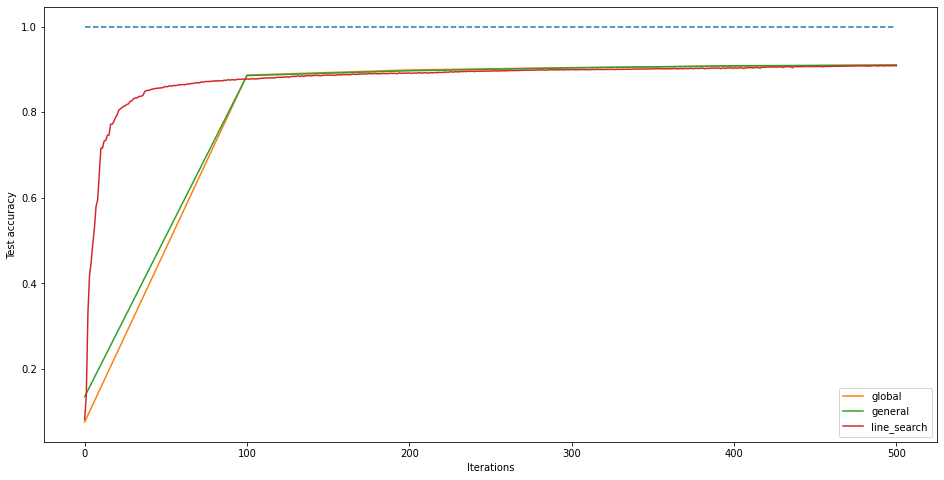

In [10]:
plt.figure(figsize = (16,8))
plt.ylabel('Test accuracy')
plt.xlabel('Iterations')
plt.plot(np.arange(500), np.ones(500), linestyle='--')

for algo in results.keys():
    test_acc = results[algo]
    if algo in ('general', 'global', 'fedavg'):
        iter_workers = 100 # number of gradient descent iterations per worker
        x = np.arange(0, 100*len(test_acc), 100)
        plt.plot(x, test_acc, label = algo)
    else:
        plt.plot(np.arange(len(test_acc)), test_acc, label = algo)
    print('-', algo)
    print('Test accuracy:{}%\n'.format(round(test_acc[-1]*100, 3)))
plt.legend();

*Note:* differences in test accuracies at the beginning of training are probably due to the random initialization.
<br>
<br>
Using general form consensus instead of global variable, how much computation do we save ?

In [0]:
 if len(train_set)%N == 0:
    lim = len(train_set)//N
else:
    lim = len(train_set)//N + 1

datasets = list(train_set)
datasets = [get_data(datasets[k*lim:(k+1)*lim]) for k in range(N)]

d_avg = 0
for i in range(N):
    X,y = datasets[i]
    non_zeros = torch.sum(X, dim = 0).squeeze().cpu().numpy().nonzero()[0].tolist()
    d_avg += 1/N*len(non_zeros)

print('Mean features to train per worker: ', round(d_avg), ' instead of ', d)
print('Average savings: ', round((d - d_avg) / d, 3)*100, '%')

Mean features to train per workerk:  584  instead of  784
Average savings:  25.5 %


Code for *FedAvg* and *DoubleSqueeze*:

In [0]:
def SGD(W, data, learning_rate = 0.01, minibatch = 10, maxiter = 100, verbose = False):
    test_acc = []
    loss = []
    pbar = tqdm.notebook.tqdm(total = maxiter, disable = not verbose)
    for t in range(maxiter):
        if verbose:
            pbar.update(1)
        zeta = np.random.randint(len(data), size = minibatch)
        X = data[0][zeta]
        y = [data[1][i] for i in zeta]
        W = W - 0.1*grad_L_i(W,X,y)
        test_acc.append(accuracy(predict(X_test, W), y_test))
        loss.append(L_i(W,X,y))
    return W, test_acc, loss

def fed_avg(subset_size = 10, sgd_iter = 100, maxiter = 10):
    #initialize training and testing sets (with the same size for each D_i)
    if len(train_set)%N == 0:
        lim = len(train_set)//N
    else:
        lim = len(train_set)//N + 1
    datasets = list(train_set)
    datasets = [get_data(datasets[k*lim:(k+1)*lim]) for k in range(N)] #N datasets: one for each worker
    X_test, y_test = get_data(test_set)

    z = torch.randn((d,K), device = device)
    W = [z.clone() for _ in range(N)]

    test_acc = [accuracy(predict(X_test, z), y_test)]
    
    pbar = tqdm.notebook.tqdm(total = maxiter)
    for _ in range(maxiter):
        pbar.update(1)
        S = np.random.randint(0, N, size = subset_size)
        delta = []
        new_z = torch.zeros_like(z)
        for i in S:
            W[i] = SGD(z.clone(), datasets[i], maxiter = sgd_iter)[0]
            new_z = new_z + (len(datasets[i])/len(train_set))*W[i]
        z = new_z.clone()
        test_acc.append(accuracy(predict(X_test, z), y_test))
    return test_acc, z

def quantize(v, nbit = 4):
    min_ = torch.min(v, dim = 0).values
    max_ = torch.max(v, dim = 0).values

    for k in range(K):
        if min_[k] == max_[k]:
            v[:,k] = torch.zeros(d)
        else:
            nv = ((v[:,k] - min_[k]) / (max_[k] - min_[k]) * (2**nbit)).type(torch.IntTensor)
            nv = nv.type(torch.FloatTensor) / (2**nbit)
            nv = nv * (max_[k] - min_[k]) + min_[k]
            v[:,k] = nv
    return v

def double_squeeze(maxiter = 100, minibatch = 10, learning_rate = 0.01):
    #initialize training and testing sets (with the same size for each D_i)
    if len(train_set)%N == 0:
        lim = len(train_set)//N
    else:
        lim = len(train_set)//N + 1
    datasets = list(train_set)
    datasets = [get_data(datasets[k*lim:(k+1)*lim]) for k in range(N)] #N datasets: one for each worker
    X_test, y_test = get_data(test_set)

    z = torch.randn((d,K), device = device)
    W = [z.clone() for _ in range(N)]

    test_acc = [accuracy(predict(X_test, z), y_test)]
    
    worker_errors = [torch.zeros_like(z) for _ in range(N)]
    server_error = torch.zeros_like(z)

    pbar = tqdm.notebook.tqdm(total = maxiter)
    for t in range(maxiter):
        pbar.update(1)
        for i in range(N):
            zeta = np.random.randint(len(datasets[i]), size = minibatch)
            X = []
            y = []
            new_z = torch.zeros_like(z)
            X = datasets[i][0][zeta]
            y = [datasets[i][1][j] for j in zeta]
            v = grad_L_i(W[i],X,y) + worker_errors[i]
            compressed_v = quantize(v)
            worker_errors[i] = v - compressed_v
            new_z += (1/N)*compressed_v
        new_z += server_error
        z = quantize(new_z.clone())
        server_error = new_z - z
        for i in range(N):
            W[i] = W[i] - learning_rate*z
        test_acc.append(accuracy(predict(X_test, z), y_test))
    return test_acc, z